In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, diff, cos, sin, sqrt, lambdify, simplify, Q, refine, nsolve
import rebound
rebound.__build__

'Aug  7 2023 15:46:31'

In [2]:
x,y, tau = symbols('x y tau', real=True)
e, E, epsilon = symbols('e E epsilon', positive=True)
dEdt = 1/(1-e*cos(E))        # Solar System Dynamics Eq. 2.50

In [3]:
dxs = [cos(E)-e]             # Solar System Dynamics Eq. 2.41
dys = [sqrt(1-e*e)*sin(E)]
for i in range(9):
    dxs.append(diff(dxs[-1],E) * dEdt)
    dys.append(diff(dys[-1],E) * dEdt)    
for i in range(len(dxs)):
    dxs[i] = dxs[i].subs(E, 0)
    dys[i] = dys[i].subs(E, 0)
dxs = lambdify(e,dxs)
dys = lambdify(e,dys)

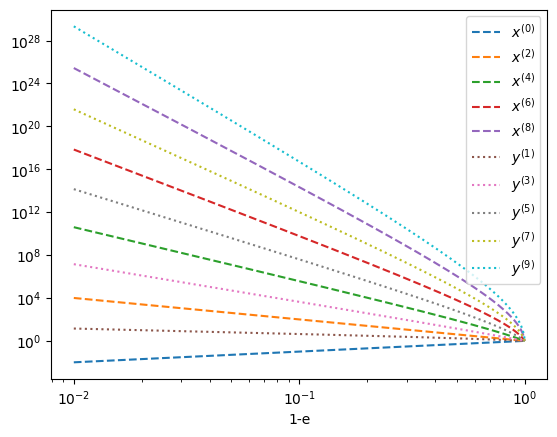

In [4]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel("1-e")
ax.set_xscale("log")
ax.set_yscale("log")
oneminuses = np.logspace(-2,-0.00001,1000)
_dxs = dxs(1.-oneminuses)
_dys = dys(1.-oneminuses)
for i in range(0,10,2):
    ax.plot(oneminuses, np.abs(_dxs[i]), ls="--", label="$x^{(%d)}$"%i)
for i in range(1,10,2):
    ax.plot(oneminuses, np.abs(_dys[i]), ls=":", label="$y^{(%d)}$"%i)
ax.legend();

In [5]:
dxs = [cos(E)-e]             # Solar System Dynamics Eq. 2.41
dys = [sqrt(1-e*e)*sin(E)]
for i in range(4):
    dxs.append(diff(dxs[-1],E) * dEdt)
    dys.append(diff(dys[-1],E) * dEdt)    
acc = sqrt(dxs[2]**2+dys[2]**2)
jerk = sqrt(dxs[3]**2+dys[3]**2)
timescale = acc/jerk
anal_dt = timescale*epsilon


In [6]:
jerk.subs(e,0.0).subs(E,0.)

1

In [7]:
anal_dt = simplify(anal_dt)
anal_dt

epsilon/(sqrt(((1 - e**2)*(-2*e*sin(E)**2 - e + cos(E))**2 + (3*e**2 - 2*e*cos(E) - 1)**2*sin(E)**2)/(e*cos(E) - 1)**10)*(e*cos(E) - 1)**2)

In [8]:
anal_dt_f = lambdify((e,E,epsilon),anal_dt)

In [9]:
dxs = [cos(E)-e]             # Solar System Dynamics Eq. 2.41
dys = [sqrt(1-e*e)*sin(E)]
for i in range(9):
    dxs.append(diff(dxs[-1],E) * dEdt)
    dys.append(diff(dys[-1],E) * dEdt)    
a = lambdify((e,E),sqrt(dxs[2]**2+dys[2]**2))
j = lambdify((e,E),sqrt(dxs[3]**2+dys[3]**2))

In [10]:
_epsilon = 3.3*np.power(1e-9,1./7.)
print(_epsilon)
_safety = 0.85
_e = 0.4

_dtaus = []
_dtau = 0.2
_tau = np.pi

while _tau<3.0*np.pi:
    # try new timestep
    _E = nsolve((E-e*sin(E)-(_tau+_dtau)).subs(e,_e),_tau,prec=50)
    _ndtau = anal_dt_f(_e, float(_E), _epsilon)
    if _ndtau > _dtau/_safety:
        print("too large")
        _ndtau = _dtau/_safety
    if _ndtau < _dtau * _safety:
        print("too small")
        pass
        
    else:
        _tau += _dtau
        _dtaus.append(_dtau)
    _dtau = _ndtau


0.17092266441463
too large
too large


In [11]:
jerk_f = lambdify((e,E),jerk)
acc_f = lambdify((e,E),acc)

In [12]:
mindt = np.zeros(100000)
mindt[:] = np.nan
count = 0
dt_last_done = 0. 
def hb(simp):
    global mindt
    global count, dt_last_done
    if dt_last_done != simp.contents.dt_last_done:        
        mindt[count] = simp.contents.dt_last_done
        count +=1 
    dt_last_done = simp.contents.dt_last_done
    
sim = rebound.Simulation()
sim.ri_ias15.dt_mode = 1
sim.ri_ias15.epsilon_global = 0
sim.add(m=1)
sim.add(a=1,e=_e,f=np.pi)
sim.dt=0.2
sim.heartbeat = hb
sim.integrate(np.pi*2.,exact_finish_time=0)

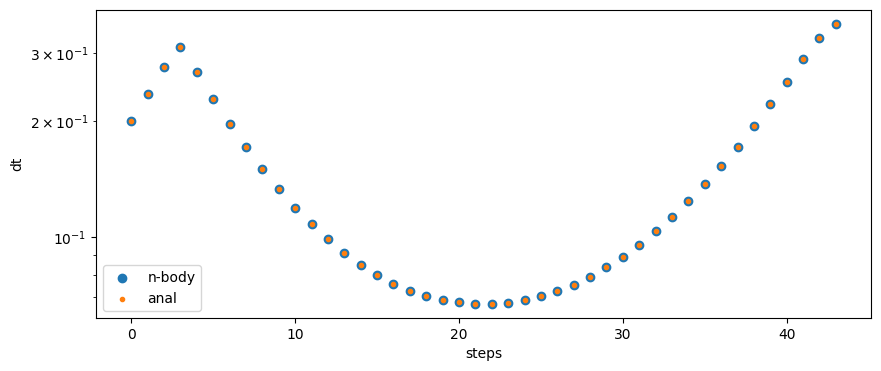

In [13]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("steps")
ax.set_ylabel("dt")
ax.set_yscale("log")
#ax.plot(mindt)
ax.scatter(np.arange(len(mindt)),mindt,label="n-body")
ax.scatter(np.arange(len(_dtaus)),np.array(_dtaus),label="anal",s=9)
ax.legend()


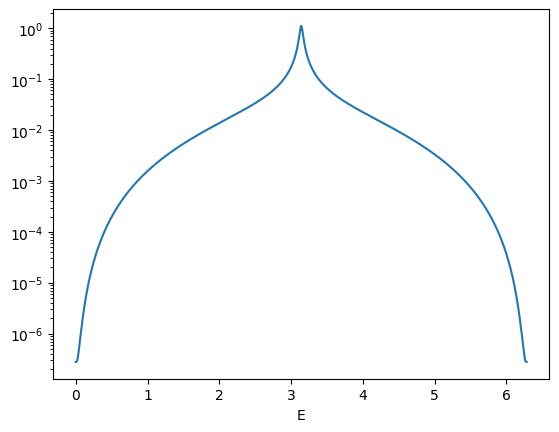

In [10]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel("E")
ax.set_yscale("log")
Es = np.linspace(0, np.pi*2.,10000)
_e = 0.999
_a = np.zeros(len(Es))
_j = np.zeros(len(Es))
for i in range(len(Es)):
    _a[i] = np.abs(a(_e, Es[i]))
    _j[i] = np.abs(j(_e, Es[i]))
#ax.plot(Es, _a)
#ax.plot(Es, _j)
dt = 0.1
epsilon = 1e-9
b0 = _j * dt
errork = _j/_a
ax.plot(Es, 1./errork*2.4*dt*np.power(1e-9,1./7.))

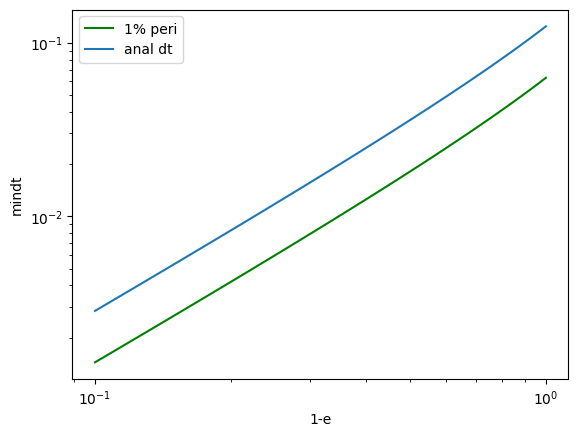

In [11]:
fig, ax = plt.subplots()
ax.set_xlabel("1-e")
ax.set_ylabel("mindt")
ax.set_xscale("log")
ax.set_yscale("log")
es = 1.-np.logspace(-1,0,100)

anal_dt = np.zeros(len(es))

for i in range(len(es)):
    Es = np.linspace(0, np.pi*2.,10000)
    _a = np.zeros(len(Es))
    _j = np.zeros(len(Es))
    for k in range(len(Es)):
        _a[k] = np.abs(a(es[i], Es[k]))
        _j[k] = np.abs(j(es[i], Es[k]))
    epsilon = 1e-9
    b0 = _j 
    errork = _j/_a
    _anal_dt = 1./errork*2.4*np.power(1e-9,1./7.)
    anal_dt[i] = np.min(_anal_dt)


ax.plot(1.-es,1e-2*2*np.pi*(1-es)**2/np.sqrt(1-es**2),label="1% peri",color="green",zorder=4)
ax.plot(1.-es,anal_dt,label="anal dt")


ax.legend()

In [23]:
def sqrt7(a):
    scale = 1
    if a<1e-7:
        a*=1e7
        scale = 10
    if a>1e2:
        a/=1e7
        scale = 0.1
    x = 1.
    for k in range(20):
        x6 = x*x*x*x*x*x
        x += (a/x6-x)/7.
    x /= scale
    return x

In [26]:
nx = np.logspace(-25,15,100)
ns = np.zeros(len(nx))
for i in range(len(nx)):
    ns[i] = sqrt7(nx[i])
ns = np.abs((ns - np.power(nx,1./7.))/np.power(nx,1./7.))

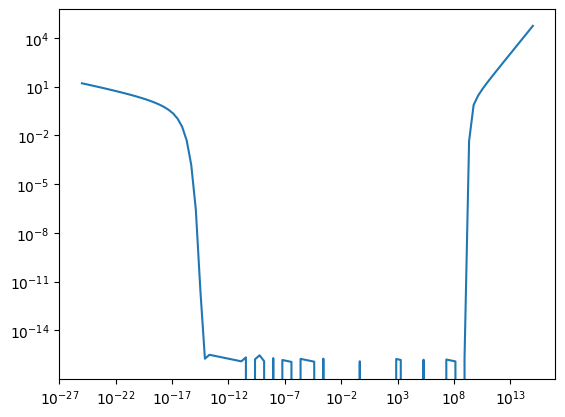

In [27]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(nx,ns)

In [19]:
1e-7**(1./7.)

0.1